In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(1)

### Testing orthogonality in Weights

In [3]:
experiment_name = 'pie_dense_unsup_fr_lin'
serialized_path = f'../serialized/experiments/{experiment_name}/'

nets = {'PIE': None, 'AE': None}

for cur in nets:
    with open(f'{serialized_path}{cur}.pt', 'rb') as outfile:
        nets[cur] = torch.load(outfile)

In [4]:
weights = {
    'PIE': {
        'U' : nets['PIE'].net.U.affine.W.weight.detach(),
        'V' : nets['PIE'].net.V.affine.W.weight.detach(),
        'U.T' : nets['PIE'].net.U.affine.W.weight.detach().T,
        'V.T' : nets['PIE'].net.V.affine.W.weight.detach().T,
    },
    'AE': {
        'U' : nets['AE'].net_fwd.U.affine.W.weight.detach(),
        'V' : nets['AE'].net_fwd.V.affine.W.weight.detach(),
        'U.T' : nets['AE'].net_bck.U.affine.W.weight.detach().T,
        'V.T' : nets['AE'].net_bck.V.affine.W.weight.detach().T,
    },
}

In [5]:
gramians = {}
for k, dct in weights.items():
    gramians[k] = {}
    for j, w in dct.items():
        gramians[k][j] = w.T @ w


In [6]:
M = 784
random_matrix_results = []

for i in tqdm(range(10000)):
    _lin = nn.Linear(M, M)
    A = _lin.weight.detach()
    SA = A.T @ A
    relerr = utils.metrics.relative_error_matrix(torch.eye(M), SA, 'fro')
    result = {'A': A, 'SA': SA, 'relative_error': relerr}
    random_matrix_results.append(result)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
relative_errors = [e['relative_error'].item() for e in random_matrix_results]

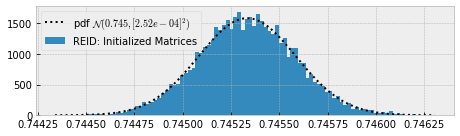

In [8]:
re_mu = np.mean(relative_errors)
re_sd = np.std(relative_errors, ddof=1)

re_range = np.linspace(min(relative_errors), max(relative_errors), 2000)
re_pdf = stats.norm.pdf(re_range, loc=re_mu, scale=re_sd)

fig, ax = plt.subplots(figsize=(6.5,2))

ax.plot(re_range, re_pdf, ':', color='k', label=f'pdf $\mathcal{{N}}({re_mu:.3f}, [{re_sd:.2e}]^2)$')
ax.hist(relative_errors, bins=100, density=True, label='REID: Initialized Matrices');
#ax.set_title('Relative Errors w.r.t. Identity: Random Matrices');
plt.legend();
plt.savefig(f'../figures/other/{experiment_name}_randmatrix_histogram.pdf')


In [9]:
# Compute likelihood of relative error observed in weights
print("Likelihood of Observing Relative Error w.r.t. Identity:")
weights_relerr = []
for k, dct in gramians.items():
    for j, sa in dct.items():
        relerr = utils.metrics.relative_error_matrix(torch.eye(M), sa, 'fro').double().item()
        weights_relerr.append(relerr)
        print(f"{k:3} - {j:12}: {stats.norm.pdf(relerr, loc=re_mu, scale=re_sd):.12E}")

Likelihood of Observing Relative Error w.r.t. Identity:
PIE - U           : 0.000000000000E+00
PIE - V           : 0.000000000000E+00
PIE - U.T         : 0.000000000000E+00
PIE - V.T         : 0.000000000000E+00
AE  - U           : 0.000000000000E+00
AE  - V           : 0.000000000000E+00
AE  - U.T         : 0.000000000000E+00
AE  - V.T         : 0.000000000000E+00


In [10]:
# Compute z-scores of results
print("Z-scores of Relative Error Observations:")
i = 0
for k, dct in gramians.items():
    for j, sa in dct.items():
        totals_relerr = relative_errors + [weights_relerr[i]]
        z_scores = stats.zscore(totals_relerr)
        relevant_zs = z_scores[-1]
        print(f"{k:3} - {j:5}: {relevant_zs}")
        i += 1

Z-scores of Relative Error Observations:
PIE - U    : -98.3129543701532
PIE - V    : -98.98720878519083
PIE - U.T  : -98.3129543701532
PIE - V.T  : -98.98720878519083
AE  - U    : -79.64649220811974
AE  - V    : 88.37415036095949
AE  - U.T  : -98.4350045721394
AE  - V.T  : -96.97281031403567


In [11]:
weights_relerr

[0.6097314953804016,
 0.5694190859794617,
 0.6097314953804016,
 0.5694190859794617,
 0.7121039628982544,
 0.7929772734642029,
 0.6044116616249084,
 0.6451444029808044]